# Conversation AI's Pinned AUC Unintended Model Bias Demo

Author: ldixon@google.com, jetpack@google.com, sorenj@google.com, nthain@google.com, lucyvasserman@google.com

***
Click [here](https://colab.research.google.com/github/conversationai/unintended-ml-bias-analysis/blob/master/unintended_ml_bias/pinned_auc_demo.ipynb) to run this colab interactively at on colab.research.google.com.

***

## Summary

This notebook demonstrates Pinned AUC as an unintended model bias metric for Conversation AI wikipedia models.

See the paper [Measuring and Mitigating Unintended Bias in Text Classification](https://github.com/conversationai/unintended-ml-bias-analysis/blob/master/presentations/measuring-mitigating-unintended-bias-paper.pdf)
for background, detailed explanation, and experimental results.

Also see  https://developers.google.com/machine-learning/fairness-overview for more info on Google's
Machine Learning Fairness work.

__Disclaimer__
*   This notebook contains experimental code, which may be changed without notice.
*   The ideas here are some ideas relevant to fairness - they are not the whole story!



We start by loading some libraries that we will use and customizing the visualization parameters.

In [0]:
!pip install -U -q git+https://github.com/conversationai/unintended-ml-bias-analysis
!pip install -U -q pandas==0.22.0

In [0]:
from unintended_ml_bias import model_bias_analysis

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import seaborn as sns
import pkg_resources

In [0]:
cm = sns.light_palette("red", as_cmap=True)

## Model Families - capture training variance
"Model Families" allows the results to capture training variance by grouping different
training versions of each model together. model_families is a list of lists, each 
sub-list ("model_family") contains the names of different training versions of the same model. 

We compare 3 versions each of three different models, **"wiki_cnn"**, **"wiki_debias_random"**,
and **"wiki_debias"**.

*   **"wiki_cnn"** is a CNN trained on the original, unmodified training data.
*   **"wiki_debias"** is the same model as wiki_cnn, but trained on a modified dataset that has undergone bias mitigation: we added presumed-non-toxic data from Wikipedia articles, specifically sampled to address the bias found in the original dataset.
*   **"wiki_debias_random"** is the same model, trained on a modified dataset that has had random Wikipedia article data added to it (not specific to the bias we found). This serves as a control for the debiasing treatment.

In [0]:
model_families = [
    ['wiki_cnn_v3_100', 'wiki_cnn_v3_101', 'wiki_cnn_v3_102'],
    ['wiki_debias_cnn_v3_100', 'wiki_debias_cnn_v3_101', 'wiki_debias_cnn_v3_102'],
    ['wiki_debias_random_cnn_v3_100', 'wiki_debias_random_cnn_v3_101', 'wiki_debias_random_cnn_v3_102'],
]

In [0]:
# Read the scored data into DataFrame
df = pd.read_csv(pkg_resources.resource_stream("unintended_ml_bias", "eval_datasets/bias_madlibs_77k_scored.csv"))

In [0]:
# Add columns for each subgroup.
terms = [line.strip() for line in pkg_resources.resource_stream("unintended_ml_bias", "bias_madlibs_data/adjectives_people.txt")]
model_bias_analysis.add_subgroup_columns_from_text(df, 'text', terms)

## Data Format
At this point, our scored data is in DataFrame df, with columns:

*   text: Full text of the comment.
*   label: True if the comment is Toxic, False otherwise.
*   < model name >: One column per model, cells contain the score from that model.
*   < subgroup >: One column per identity, True if the comment mentions this identity.

You can run the analysis below on any data in this format. Subgroup labels can be 
generated via words in the text as done above, or come from human labels if you have them.


# Unintended Bias Metrics

## Pinned AUC
Pinned AUC measures the extent of unintended bias of a real-value score function
by measuring each sub-group's divergence from the general distribution.

Let $D$ represent the full data set and $D_g$ be the set of examples in subgroup
$g$. Then:


$$ Pinned \ dataset \ for \ group \ g = pD_g = s(D_g) + s(D), |s(D_g)| = |s(D)| $$

$$ Pinned \ AUC \ for \ group \ g = pAUC_g = AUC(pD_g) $$

$$ Pinned \ AUC \ Squared \ Equality \ Difference = \Sigma_{g \in G}(AUC - pAUC_g)^2 $$


## Pinned AUC Equality Difference
The table below shows the pinned AUC equality difference for each model family.
Lower scores (lighter red) represent more similarity between each group's pinned AUC, which means
less unintended bias.

On this set, the wiki_debias_cnn model demonstrates least unintended bias. 

In [17]:
eq_diff = model_bias_analysis.per_subgroup_auc_diff_from_overall(df, terms, model_families, squared_error=True)
# sort to guarantee deterministic output
eq_diff.sort_values(by=['model_family'], inplace=True)
eq_diff.reset_index(drop=True, inplace=True)
eq_diff.style.background_gradient(cmap=cm)

,model_family,pinned_auc_equality_difference
0,wiki_cnn_v3_10,0.0361856
1,wiki_debias_cnn_v3_10,0.0155199
2,wiki_debias_random_cnn_v3_10,0.0763675


## Pinned AUC Graphs
The graphs below show per-group Pinned AUC for each subgroup and each model. Each
identity group shows 3 points, each representing the pinned AUC for one training 
version of the model. More consistency among the values represents less unintended bias.

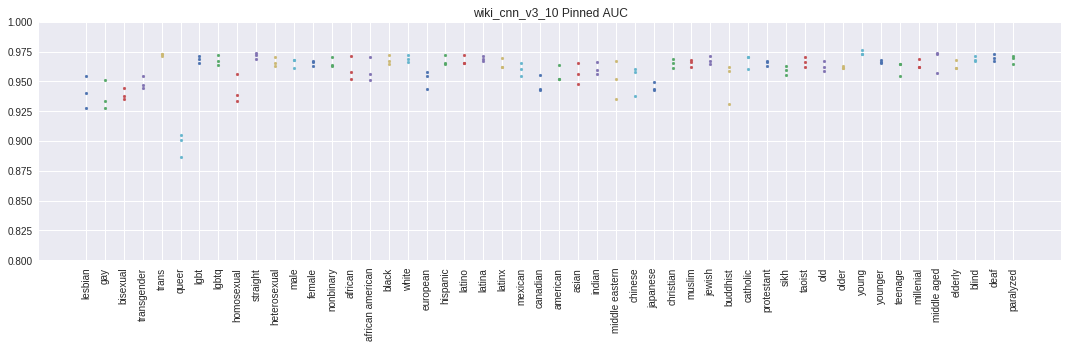

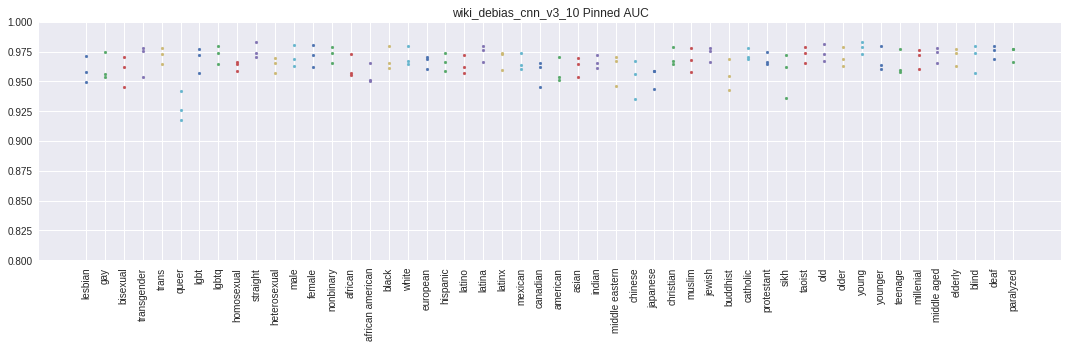

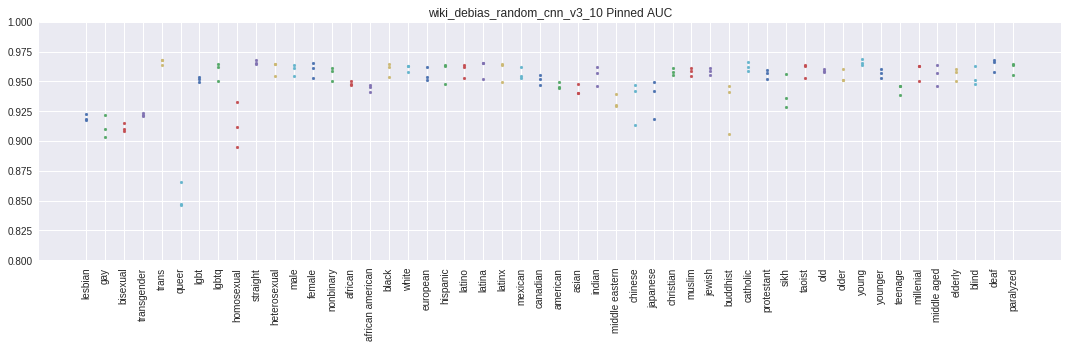

In [18]:
pinned_auc_results = model_bias_analysis.per_subgroup_aucs(df, terms, model_families, 'label')
for family in model_families:
  name = model_bias_analysis.model_family_name(family)
  model_bias_analysis.per_subgroup_scatterplots(
      pinned_auc_results,
      'subgroup',
      name + '_aucs',
      name + ' Pinned AUC',
      y_lim=(0.8, 1.0))